# BioSTEAM Process Flowsheet Simulation

This notebook demonstrates how to simulate process flowsheets using the biosteam Python package.

## Overview
- Setting up thermodynamic models
- Creating streams with compositions
- Building unit operations
- Connecting units into systems
- Running simulations
- Analyzing results


In [1]:
# Import required packages
import biosteam as bst
from biosteam import units, Stream, System, Reaction
import numpy as np
import matplotlib.pyplot as plt

# Enable light-mode HTML diagrams and filter warnings for Jupyter
# Note: If you get llvmlite errors, see the troubleshooting cell below
try:
    bst.nbtutorial()
except (OSError, KeyError) as e:
    if 'llvmlite' in str(e) or 'LLVM' in str(e):
        print("WARNING: llvmlite/numba issue detected. Some features may be slower.")
        print("To fix, run in terminal: pip install numpy==1.26.4 numba==0.60.0 llvmlite==0.43.0")
        print("Continuing with limited numba support...")
    else:
        raise


## Troubleshooting: llvmlite/numba Issues

If you encounter `llvmlite` or `numba` errors (common on macOS), this is usually a version compatibility issue. 

**Fix:**
```bash
# Activate your virtual environment first
source venv/bin/activate  # or: venv\Scripts\activate on Windows

# Install compatible versions (required by thermosteam)
pip install numpy==1.26.4 numba==0.60.0 llvmlite==0.43.0
```

**Note:** The notebook will still work even with numba warnings, but some calculations may be slower. The error handling in the first code cell will allow the notebook to continue running.

---

## Step 1: Set Up Thermodynamic Model

Define the chemical components and set up the thermodynamic database.


In [2]:
# Set up thermodynamic model with chemical components
bst.settings.set_thermo(
    ['Water', 'He', 'CO2', 'Cellulose', 'Hemicellulose', 'Lignin', 'Ash',
     'Glucose', 'Xylose', 'Arabinose', 'Sucrose', 'Fructose', 'Furfural',
     'Acetic Acid', 'Formic Acid', 'H2SO4'],
    db='BioSTEAM'
)

# Create a named flowsheet (optional - uses 'default' if not specified)
bst.main_flowsheet.set_flowsheet('HTL_process')
print("Thermodynamic model set up successfully!")


Thermodynamic model set up successfully!


## Step 2: Define Feed Streams

Create input streams with specified compositions and flow rates.


In [3]:
# Define chemical groups for easier stream specification (optional)
chemicals = bst.settings.chemicals
chemicals.define_group(
    name='Fiber',
    IDs=['Cellulose', 'Hemicellulose', 'Lignin'],
    composition=[0.4704, 0.2775, 0.2520],
    wt=True  # Composition is given as weight fraction
)

# Create feed stream - biomass slurry
feed = Stream(
    'feed',
    Water=880,           # kg/hr
    Cellulose=36.17,
    Hemicellulose=19.68,
    Lignin=17.66,
    Ash=4.59,
    Glucose=1.86,
    Xylose=1.30,
    units='kg/hr',
    T=298.15,  # 25°C
    P=101325   # 1 atm
)

print("Feed stream created:")
feed.show()


Feed stream created:
Stream: feed
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water          48.8
                Cellulose      0.223
                Hemicellulose  0.149
                Lignin         0.116
                Ash            4.59
                Glucose        0.0103
                Xylose         0.00866


## Step 3: Create Unit Operations

Build unit operations and connect them via streams.


In [4]:
# Pump to increase pressure
P1 = units.Pump('P1', feed)

# Heat exchanger to preheat feed
H1 = units.HXutility('H1', P1-0, T=573.15)  # 300°C

print("Created pump and preheater")


Created pump and preheater


## Step 4: Define Reactions and Reactor

Set up reactions that occur in the HTL reactor.

**Important Notes:**

1. **Chemical names with spaces:** When defining reactions with chemicals that have spaces in their names (e.g., "Acetic Acid", "Formic Acid"), use **dictionary format** instead of string format to avoid parsing errors:
   - ❌ String format: `'Xylose -> Acetic Acid'` (fails - spaces get stripped)
   - ✅ Dictionary format: `{'Xylose': -1, 'Acetic Acid': 1}` (works correctly)

2. **Multiple reactions:** BioSTEAM's `SinglePhaseReactor` accepts a single `reaction` parameter. To use multiple reactions, combine them using `ParallelReaction`:
   - Use `ParallelReaction([r1, r2, r3, ...])` to combine multiple Reaction objects


In [9]:
# Import ParallelReaction to combine multiple reactions
from biosteam import ParallelReaction

# Define reactions
# Note: For chemicals with spaces (like "Acetic Acid"), use dictionary format
# instead of string format to avoid parsing issues

r1 = Reaction(
    'Hemicellulose -> Xylose',
    reactant='Hemicellulose',
    X=0.941  # 94.1% conversion
)

r2 = Reaction(
    'Cellulose -> Glucose',
    reactant='Cellulose',
    X=0.492  # 49.2% conversion
)

# Use dictionary format for reactions with chemicals that have spaces in their names
r3 = Reaction(
    {'Xylose': -1, 'Furfural': 0.25, 'Acetic Acid': 1, 'Formic Acid': 0.10},
    reactant='Xylose',
    X=0.12  # 12% decomposition
)

r4 = Reaction(
    {'Glucose': -1, 'Acetic Acid': 1, 'Formic Acid': 1},
    reactant='Glucose',
    X=0.08  # 8% decomposition
)

# Combine all reactions into a ParallelReaction
# This allows multiple reactions to occur simultaneously
combined_reactions = ParallelReaction([r1, r2, r3, r4])

print("Reactions defined:")
for i, r in enumerate([r1, r2, r3, r4], 1):
    print(f"  r{i}: {r}")
print(f"\nCombined reactions: {combined_reactions}")


Reactions defined:
  r1: Reaction('Hemicellulose -> Xylose', reactant='Hemicellulose', X=0.941, basis='mol')
  r2: Reaction('Cellulose -> Glucose', reactant='Cellulose', X=0.492, basis='mol')
  r3: Reaction('Xylose -> 0.25 Furfural + Acetic Acid + 0.1 Formic Acid', reactant='Xylose', X=0.12, basis='mol')
  r4: Reaction('Glucose -> Acetic Acid + Formic Acid', reactant='Glucose', X=0.08, basis='mol')

Combined reactions: ParallelReaction([Reaction('Hemicellulose -> Xylose', reactant='Hemicellulose', X=0.941, basis='mol'), Reaction('Cellulose -> Glucose', reactant='Cellulose', X=0.492, basis='mol'), Reaction('Xylose -> 0.25 Furfural + Acetic Acid + 0.1 Formic Acid', reactant='Xylose', X=0.12, basis='mol'), Reaction('Glucose -> Acetic Acid + Formic Acid', reactant='Glucose', X=0.08, basis='mol')])


In [10]:
# Create reactor with combined reactions
# Note: SinglePhaseReactor takes a single 'reaction' parameter
# Use ParallelReaction to combine multiple reactions
R1 = units.SinglePhaseReactor(
    'R1',
    ins=H1-0,
    reaction=combined_reactions,  # Single reaction object (can be ParallelReaction)
    T=573.15,  # 300°C
    P=20e5,    # 20 bar
    tau=1.0  # 1 hour residence time (in hours, not seconds)
)

print("Reactor created and connected")


Reactor created and connected


## Step 5: Add Separation Units

Add flash separator and other separation units.


In [11]:
# Flash separator to separate vapor and liquid phases
F1 = units.Flash(
    'F1',
    ins=R1-0,
    T=298.15,  # Flash at ambient temperature
    P=101325
)

# Heat exchanger to cool product
H2 = units.HXutility('H2', F1-0, T=313.15)  # Cool vapor to 40°C

# Storage tank
T1 = units.StorageTank('T1', F1-1, tau=4)  # 4 hour residence time for liquid phase

print("Separation units created:")
print(f"  - Flash separator: {F1.ID}")
print(f"  - Cooler: {H2.ID}")
print(f"  - Storage tank: {T1.ID}")


Separation units created:
  - Flash separator: F1
  - Cooler: H2
  - Storage tank: T1


## Step 6: Create System and Simulate

Create a System object from the units and run the simulation.


In [12]:
# Define the system by specifying which units are included
# The order matters - units will be simulated in this order
system = System(
    'HTL_system',
    path=[
        P1,      # Pump
        H1,      # Preheat
        R1,      # Reactor
        F1,      # Flash separator
        H2,      # Cooler
        T1       # Storage
    ]
)

print(f"System '{system.ID}' created with {len(system.units)} units")


System 'HTL_system' created with 6 units


In [13]:
# Simulate the entire flowsheet
print("Running simulation...")
system.simulate()
print("Simulation completed successfully!")


Running simulation...
Simulation completed successfully!


## Step 7: View Results

Display stream compositions and key metrics.


In [14]:
print("=" * 60)
print("FEED STREAM:")
print("=" * 60)
feed.show()

print("\n" + "=" * 60)
print("REACTOR OUTPUT:")
print("=" * 60)
(R1.outs[0]).show()

print("\n" + "=" * 60)
print("FLASH VAPOR OUTPUT:")
print("=" * 60)
(F1.outs[0]).show()  # Vapor phase

print("\n" + "=" * 60)
print("FLASH LIQUID OUTPUT:")
print("=" * 60)
(F1.outs[1]).show()  # Liquid phase


FEED STREAM:
Stream: feed to <Pump: P1>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water          48.8
                Cellulose      0.223
                Hemicellulose  0.149
                Lignin         0.116
                Ash            4.59
                Glucose        0.0103
                Xylose         0.00866

REACTOR OUTPUT:
MultiStream: s3 from <SinglePhaseReactor: R1> to <Flash: F1>
phases: ('g', 'l'), T: 485.69 K, P: 2e+06 Pa
flow (kmol/hr): (g) Water          11.2
                    Furfural       0.000143
                    Acetic Acid    0.00038
                    Formic Acid    6.75e-05
                (l) Water          37.7
                    Cellulose      0.113
                    Hemicellulose  0.00879
                    Lignin         0.116
                    Ash            4.59
                    Glucose        0.119
                    Xylose         0.148
                    ...            0.00246

FLASH VAPOR OUTPUT:
Stream: s4 from <

In [15]:
# Get specific properties and key metrics
print("=" * 60)
print("KEY METRICS:")
print("=" * 60)
print(f"Total feed flow rate: {feed.F_mass:.2f} kg/hr")
print(f"Water flow rate in feed: {feed.imass['Water']:.2f} kg/hr")
print(f"Glucose flow rate in reactor output: {(R1.outs[0]).imass['Glucose']:.4f} kg/hr")
print(f"Xylose flow rate in reactor output: {(R1.outs[0]).imass['Xylose']:.4f} kg/hr")
print(f"Acetic Acid flow rate in reactor output: {(R1.outs[0]).imass['Acetic Acid']:.4f} kg/hr")
print(f"Furfural flow rate in reactor output: {(R1.outs[0]).imass['Furfural']:.4f} kg/hr")


KEY METRICS:
Total feed flow rate: 961.26 kg/hr
Water flow rate in feed: 880.00 kg/hr
Glucose flow rate in reactor output: 21.4841 kg/hr
Xylose flow rate in reactor output: 22.1881 kg/hr
Acetic Acid flow rate in reactor output: 0.1120 kg/hr
Furfural flow rate in reactor output: 0.0250 kg/hr


In [16]:
# Unit operation costs and utilities
print("=" * 60)
print("UNIT OPERATION DETAILS:")
print("=" * 60)
print(f"Reactor {R1.ID}:")
print(f"  - Temperature: {R1.T:.2f} K ({R1.T-273.15:.2f}°C)")
print(f"  - Pressure: {R1.P/1e5:.2f} bar")
if hasattr(R1, 'H_net'):
    print(f"  - Heat duty: {R1.H_net/1e6:.2f} MW")
if hasattr(R1, 'power_utility') and R1.power_utility:
    print(f"  - Power requirement: {R1.power_utility.consumption:.2f} kW")

print(f"\nPump {P1.ID}:")
if hasattr(P1, 'power_utility') and P1.power_utility:
    print(f"  - Power requirement: {P1.power_utility.consumption:.2f} kW")


UNIT OPERATION DETAILS:
Reactor R1:
  - Temperature: 573.15 K (300.00°C)
  - Pressure: 20.00 bar
  - Power requirement: 1.67 kW

Pump P1:
  - Power requirement: 0.08 kW


## Step 8: Generate Flowsheet Diagram

Create a visual representation of the flowsheet.


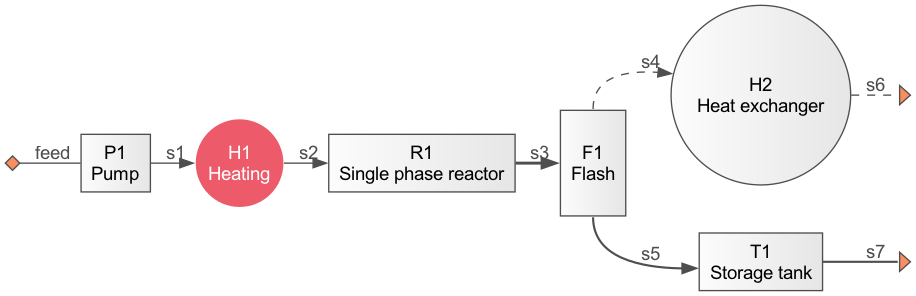

In [18]:
# Create a diagram of the flowsheet
# This will display inline in Jupyter
bst.main_flowsheet.diagram(format='jpg')

# To save as PNG file:
# bst.main_flowsheet.diagram(format='png', file='HTL_flowsheet.png')


## Step 9: Parameter Studies

Perform sensitivity analysis by varying process parameters.


In [19]:
# Study effect of temperature on conversion
temperatures = np.linspace(500, 600, 11)  # 227-327°C
glucose_production = []
xylose_production = []
acetic_acid_production = []

print("Running temperature sensitivity analysis...")
for T in temperatures:
    R1.T = T
    system.simulate()
    glucose_production.append((R1.outs[0]).imass['Glucose'])
    xylose_production.append((R1.outs[0]).imass['Xylose'])
    acetic_acid_production.append((R1.outs[0]).imass['Acetic Acid'])

print("Temperature sensitivity results:")
print(f"{'Temperature (°C)':<20} {'Glucose (kg/hr)':<20} {'Xylose (kg/hr)':<20} {'Acetic Acid (kg/hr)':<20}")
print("-" * 80)
for T, g, x, a in zip(temperatures, glucose_production, xylose_production, acetic_acid_production):
    print(f"{T-273.15:>10.1f}          {g:>15.4f}  {x:>15.4f}  {a:>15.4f}")


Running temperature sensitivity analysis...
Temperature sensitivity results:
Temperature (°C)     Glucose (kg/hr)      Xylose (kg/hr)       Acetic Acid (kg/hr) 
--------------------------------------------------------------------------------
     226.9                  21.4841          22.1881           0.1120
     236.9                  21.4841          22.1881           0.1120
     246.9                  21.4841          22.1881           0.1120
     256.9                  21.4841          22.1881           0.1120
     266.9                  21.4841          22.1881           0.1120
     276.9                  21.4841          22.1881           0.1120
     286.9                  21.4841          22.1881           0.1120
     296.9                  21.4841          22.1881           0.1120
     306.9                  21.4841          22.1881           0.1120
     316.9                  21.4841          22.1881           0.1120
     326.9                  21.4841          22.1881      

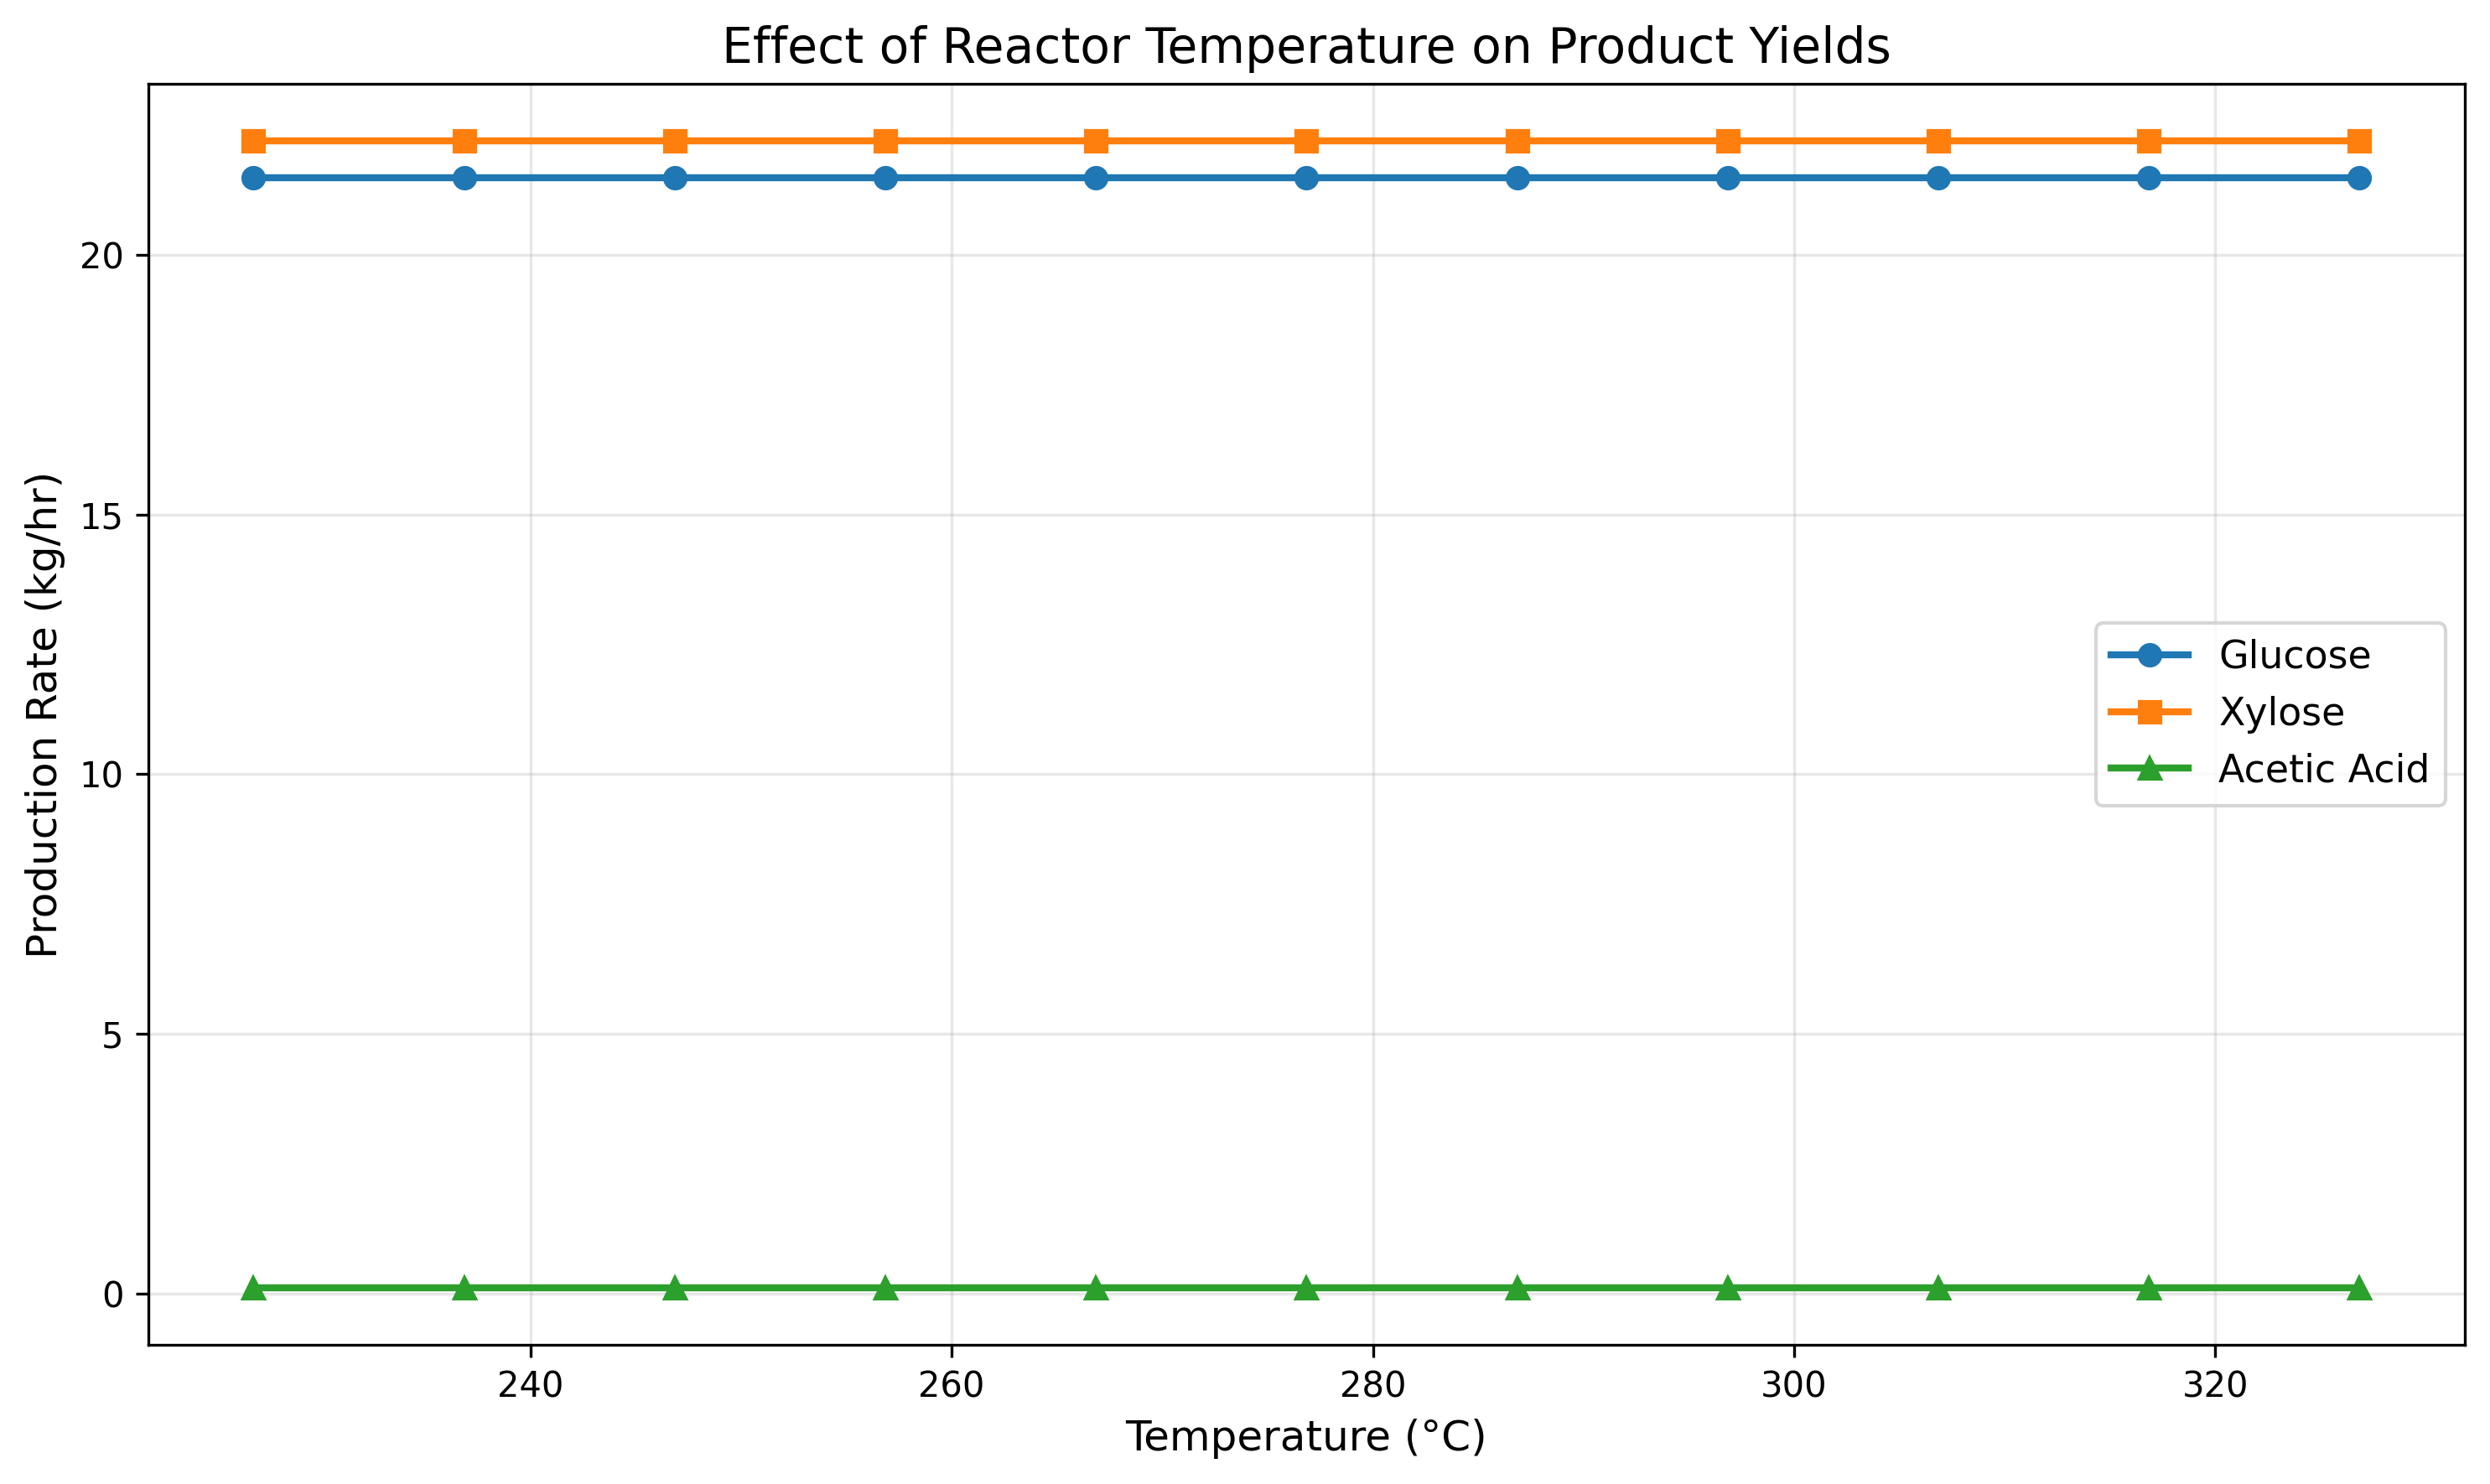

In [20]:
# Plot temperature sensitivity
plt.figure(figsize=(10, 6))
plt.plot(temperatures - 273.15, glucose_production, 'o-', label='Glucose', linewidth=2)
plt.plot(temperatures - 273.15, xylose_production, 's-', label='Xylose', linewidth=2)
plt.plot(temperatures - 273.15, acetic_acid_production, '^-', label='Acetic Acid', linewidth=2)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Production Rate (kg/hr)', fontsize=12)
plt.title('Effect of Reactor Temperature on Product Yields', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Step 10: System Specifications (Advanced)

Add specifications that run after simulation for process control and recycle streams.


In [21]:
# Example: Add a specification that adjusts reactor pressure based on feed flow
# First, reset reactor to original temperature
R1.T = 573.15

@R1.add_specification(run=True)
def update_reactor_pressure():
    """Adjust pressure based on feed flow rate"""
    feed_flow = feed.F_mass
    # Pressure proportional to flow (example: 15 bar base + flow factor)
    R1.P = 15e5 + (feed_flow / 1000) * 1e5

# Re-run with specifications
system.simulate()

print("After adding specifications:")
print(f"  Feed flow rate: {feed.F_mass:.2f} kg/hr")
print(f"  Reactor pressure: {R1.P/1e5:.2f} bar")
print(f"  Reactor temperature: {R1.T:.2f} K ({R1.T-273.15:.2f}°C)")


After adding specifications:
  Feed flow rate: 961.26 kg/hr
  Reactor pressure: 15.96 bar
  Reactor temperature: 573.15 K (300.00°C)


## Example 2: Simple Material Balance Flowsheet

A simpler example demonstrating mixing and splitting operations.


In [22]:
# Create a new flowsheet for the simple example
simple_flowsheet = bst.Flowsheet('simple_example')

with simple_flowsheet:
    # Set up simpler thermodynamic model
    bst.settings.set_thermo(['Water', 'Glucose', 'Salt'], cache=True)
    
    # Create streams
    feed1 = Stream('feed1', Water=100, Glucose=50, units='kg/hr')
    feed2 = Stream('feed2', Water=200, Salt=10, units='kg/hr')
    
    # Create units
    M1 = units.Mixer('M1', [feed1, feed2])
    S1 = units.Splitter('S1', M1-0, split=0.8)  # 80% to first output
    T1 = units.StorageTank('T1', S1-0, tau=1)  # 1 hour residence time
    
    # Create and run system
    simple_system = System('simple_system', path=[M1, S1, T1])
    simple_system.simulate()
    
    print("Simple flowsheet results:")
    print("\nMixer output:")
    (M1.outs[0]).show()
    print("\nSplitter - main output (80%):")
    (S1.outs[0]).show()
    print("\nSplitter - split output (20%):")
    (S1.outs[1]).show()

# Switch back to main flowsheet
bst.main_flowsheet.set_flowsheet('HTL_process')


Simple flowsheet results:

Mixer output:
Stream: s10 from <Mixer: M1> to <Splitter: S1>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water    16.7
                Glucose  0.278
                Salt     0.171

Splitter - main output (80%):
Stream: s11 from <Splitter: S1> to <StorageTank: T1>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water    13.3
                Glucose  0.222
                Salt     0.137

Splitter - split output (20%):
Stream: s12 from <Splitter: S1>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water    3.33
                Glucose  0.0555
                Salt     0.0342


## Summary

This notebook demonstrated:
1. ✅ Setting up thermodynamic models
2. ✅ Creating streams with compositions
3. ✅ Building unit operations (pumps, heat exchangers, reactors, separators)
4. ✅ Connecting units via streams
5. ✅ Creating and running Systems
6. ✅ Viewing results and metrics
7. ✅ Parameter sensitivity studies
8. ✅ Adding system specifications
9. ✅ Generating flowsheet diagrams

For more information, visit the [BioSTEAM documentation](https://biosteam.readthedocs.io/).
